<a href="https://colab.research.google.com/github/Debottam/MachinLearningEx/blob/master/tripletVAE_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random
from sklearn.utils import check_random_state
from sklearn.decomposition import PCA

In [2]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [4]:
# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

In [5]:
def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

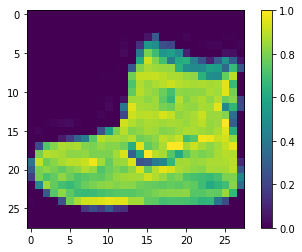

label:  9


In [6]:
show_image(train_images[0])
print("label: ",train_labels[0])

In [7]:
image_shoe_index = np.where(train_labels==9)
train_image_shoe = train_images[image_shoe_index]
print("shape before flattening: ",train_image_shoe.shape)
train_image_shoe_flatten = np.reshape(train_image_shoe, (6000, 784))
print("shape after flattening: ",train_image_shoe_flatten.shape)

shape before flattening:  (6000, 28, 28)
shape after flattening:  (6000, 784)


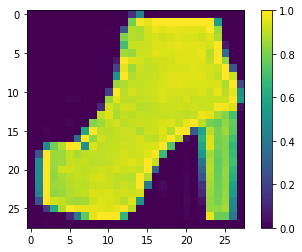

In [8]:
show_image(train_image_shoe[4])

In [9]:
image_tshirt_index = np.where(train_labels==0)
train_image_tshirt = train_images[image_tshirt_index]
print("shape before flattening: ",train_image_tshirt.shape)
train_image_tshirt_flatten = np.reshape(train_image_tshirt, (6000, 784))
print("shape after flattening: ",train_image_tshirt_flatten.shape)

shape before flattening:  (6000, 28, 28)
shape after flattening:  (6000, 784)


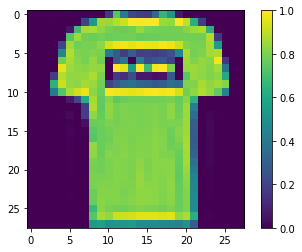

In [10]:
show_image(train_image_tshirt[0])

In [11]:
image_tshirt_index = np.where(test_labels==0)
test_image_tshirt = test_images[image_tshirt_index]
print("shape before flattening: ",test_image_tshirt.shape)
test_image_tshirt_flatten = np.reshape(test_image_tshirt, (1000, 784))
print("shape after flattening: ",test_image_tshirt_flatten.shape)

shape before flattening:  (1000, 28, 28)
shape after flattening:  (1000, 784)


In [12]:
image_trouser_index = np.where(train_labels==1)
train_image_trouser = train_images[image_trouser_index]
print("shape before flattening: ",train_image_trouser.shape)
train_image_trouser_flatten = np.reshape(train_image_trouser, (6000, 784))
print("shape after flattening: ",train_image_trouser_flatten.shape)

shape before flattening:  (6000, 28, 28)
shape after flattening:  (6000, 784)


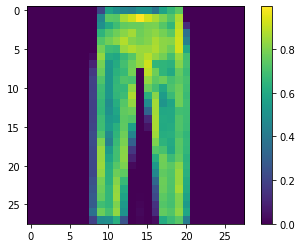

In [13]:
show_image(train_image_trouser[0])

In [14]:
image_trouser_index = np.where(test_labels==1)
test_image_trouser = test_images[image_trouser_index]
print("shape before flattening: ",test_image_trouser.shape)
test_image_trouser_flatten = np.reshape(test_image_trouser, (1000, 784))
print("shape after flattening: ",test_image_trouser_flatten.shape)

shape before flattening:  (1000, 28, 28)
shape after flattening:  (1000, 784)


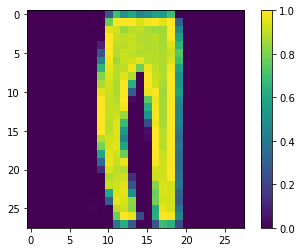

In [15]:
show_image(test_image_trouser[0])

In [16]:
def plot_triplet(triplet):
  plt.figure(figsize=(6,2))
  for i in range(0,3):
    plt.subplot(1,3,i+1)
    plt.imshow(np.reshape(triplet[i],(28,28)), cmap='binary')
    plt.xticks([])
    plt.yticks([])
  plt.show()

In [17]:
class PCAPlotter(tf.keras.callbacks.Callback):
    
    def __init__(self, plt, embedding_model, x_test, y_test):
        super(PCAPlotter, self).__init__()
        self.embedding_model = embedding_model
        self.x_test = x_test
        self.y_test = y_test
        self.fig = plt.figure(figsize=(9, 4))
        self.ax1 = plt.subplot(1, 2, 1)
        self.ax2 = plt.subplot(1, 2, 2)
        plt.ion()
        
        self.losses = []
    
    def plot(self, epoch=None, plot_loss=False):
        x_test_embeddings = self.embedding_model.predict(self.x_test)
        pca_out = PCA(n_components=2).fit_transform(x_test_embeddings)
        self.ax1.clear()
        self.ax1.scatter(pca_out[:, 0], pca_out[:, 1], c=self.y_test, cmap='seismic')
        if plot_loss:
            self.ax2.clear()
            self.ax2.plot(range(epoch), self.losses)
            self.ax2.set_xlabel('Epochs')
            self.ax2.set_ylabel('Loss')
        self.fig.canvas.draw()
    
    def on_train_begin(self, logs=None):
        self.losses = []
        self.fig.show()
        self.fig.canvas.draw()
        self.plot()

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('loss'))
        self.plot(epoch+1, plot_loss=True)

In [18]:
# concatenating tshirt and trouser
training_X = np.concatenate((train_image_tshirt_flatten,train_image_trouser_flatten), axis = 0)
# concatenating test tshirt and trouser
testing_X = np.concatenate((test_image_tshirt_flatten,test_image_trouser_flatten), axis = 0)
training_X.shape

(12000, 784)

In [19]:
# generate labels tshirt = 0 and trouser = 1
train_y = np.concatenate((np.zeros(len(train_image_tshirt_flatten)), np.ones(len(train_image_trouser_flatten))), axis=0)

# test generate labels tshirt = 0 and trouser = 1
test_y = np.concatenate((np.zeros(len(test_image_tshirt_flatten)), np.ones(len(test_image_trouser_flatten))), axis=0)

In [ ]:
#rng = check_random_state(1)
#indices = rng.permutation(len(training_X))
#indices_test = rng.permutation(len(testing_X))


In [ ]:
# shuffled data and labels
# training_X_shuffled = training_X[indices]
# train_y_shuffled = train_y[indices]

# test shuffled data and labels
# testing_X_shuffled = testing_X[indices_test]
# test_y_shuffled = test_y[indices_test]

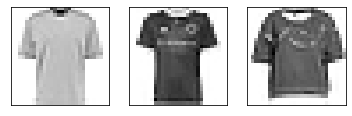

In [20]:
#print(train_y_shuffled[6000],train_y_shuffled[6001],train_y_shuffled[6002])
plot_triplet([training_X[5999],training_X[5998],training_X[5997]])

In [21]:
def create_batch (batch_size):
  anchors = np.zeros((batch_size, 784))
  positives = np.zeros((batch_size, 784))
  negatives = np.zeros((batch_size, 784))

  for i in range(0,batch_size):
    index = random.randint(0,6000-1)
    anc = training_X[index]
    y = train_y[index]

    indices_for_pos = np.squeeze(np.where(train_y == y))
    indices_for_neg = np.squeeze(np.where(train_y != y))

    pos = training_X[indices_for_pos[random.randint(0,len(indices_for_pos)-1)]]
    neg = training_X[indices_for_neg[random.randint(0,len(indices_for_neg)-1)]]

    anchors[i] = anc
    positives[i] = pos
    negatives[i] = neg

    return [anchors, positives, negatives] 

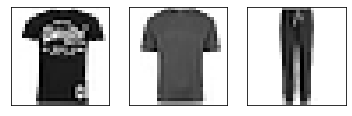

In [22]:
triplet = create_batch (1)
plot_triplet(triplet)

In [23]:
encoding_dim = 64
def sampling(args):
    mu, sigma = args
    batch     = tf.shape(mu)[0]
    dim       = tf.shape(mu)[1]
    eps       = tf.keras.backend.random_normal(shape=(batch, dim))
    return mu + tf.exp(sigma / 2) * eps

In [24]:
class _Encoder(Model):
    def __init__(self, **kwargs):
        super(_Encoder, self).__init__(**kwargs)
        self.layer_1 = Dense(256, activation="relu")
        self.layer_2 = Dense(128, activation="relu")
        self.layer_3 = Dense(64, activation="relu")
    
    def call(self,inputs):
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        self.mean = Dense(encoding_dim, name="z_mean")(x)
        self.log_var = Dense(encoding_dim, name="z_log_var")(x)
        self.z = Lambda(sampling, output_shape=(encoding_dim,), name='z')([self.mean, self.log_var])
        return self.z, self.mean, self.log_var

In [25]:
class _Decoder(Model):
    def __init__(self, **kwargs):
        super(_Decoder, self).__init__(**kwargs)
        self.layer_1 = Dense(128, activation="relu")
        self.layer_2 = Dense(256, activation="relu")
        self.layer_3 = Dense(784, activation="sigmoid")
        
    def call(self,inputs):
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        output = self.layer_3(x)
        return output


In [26]:
# kl divergence loss
# https://keras.io/examples/generative/vae/

def kl_reconstruction_loss(x, recon_x, mu, log_var):
    reco_loss = tf.reduce_sum(tf.pow(x - recon_x,2), axis= -1)
    kl_loss = 1 + log_var - tf.square(mu) - tf.exp(log_var)
    kl_loss = tf.reduce_sum(kl_loss, axis= -1)
    kl_loss *= -0.5
    return tf.reduce_mean(reco_loss + kl_loss)

In [ ]:
'''
class Tripletnet(Model):
    def __init__(self, embeddingnet):
        super(Tripletnet, self).__init__()
        self.embeddingnet = embeddingnet

    def forward(self, x, y, z):
        latent_x,mean_x,logvar_x = self.embeddingnet(x)
        latent_y,mean_y,logvar_y = self.embeddingnet(y)
        latent_z,mean_z,logvar_z = self.embeddingnet(z)
        dist_a = F.pairwise_distance(mean_x, mean_y, 2)
        dist_b = F.pairwise_distance(mean_x, mean_z, 2)
        return latent_x,mean_x,logvar_x,\
            latent_y,mean_y,logvar_y,\
            latent_z,mean_z,logvar_z,\
            dist_a, dist_b
'''

'\nclass Tripletnet(Model):\n    def __init__(self, embeddingnet):\n        super(Tripletnet, self).__init__()\n        self.embeddingnet = embeddingnet\n\n    def forward(self, x, y, z):\n        latent_x,mean_x,logvar_x = self.embeddingnet(x)\n        latent_y,mean_y,logvar_y = self.embeddingnet(y)\n        latent_z,mean_z,logvar_z = self.embeddingnet(z)\n        dist_a = F.pairwise_distance(mean_x, mean_y, 2)\n        dist_b = F.pairwise_distance(mean_x, mean_z, 2)\n        return latent_x,mean_x,logvar_x,            latent_y,mean_y,logvar_y,            latent_z,mean_z,logvar_z,            dist_a, dist_b\n'

In [33]:
batch_size= 60
steps = int(12000/batch_size)
encoder = _Encoder()
decoder = _Decoder()
alpha = 0.2
optimizer = tf.keras.optimizers.Adam()

In [ ]:
list1 = [1,2,3]
list2 = [4,5,6]

In [ ]:
list = list1 + list2

In [ ]:
list

[1, 2, 3, 4, 5, 6]

In [34]:
epochs = 40
epochs_train_losses = []
for epoch in range(epochs):
  print('Start of epoch',epoch)
  losses = []
  for step in range(0,steps):
    #print('Step: ', step)
    anc, pos, neg = create_batch (batch_size)
    anc_pos = np.concatenate((anc,pos), axis = 0)
    #print("anc.shape:",anc.shape)
    #print("pos.shape:",pos.shape)
    #print("neg.shape:",neg.shape)
    with tf.GradientTape() as tape:
      latent_anc,mean_anc,log_var_anc = encoder(anc)
      latent_pos,mean_pos,log_var_pos = encoder(pos)
      latent_neg,mean_neg,log_var_neg = encoder(neg)
      latent_anc_pos = np.concatenate((latent_anc,latent_pos), axis = 0)
      mean_anc_pos = np.concatenate((mean_anc,mean_pos), axis = 0)
      log_var_anc_pos = np.concatenate((log_var_anc,log_var_pos), axis = 0)
      dp = tf.reduce_mean(tf.square(mean_anc - mean_pos), axis = -1)
      dn = tf.reduce_mean(tf.square(mean_anc - mean_neg), axis = -1)
      triplet_loss = tf.maximum(dp-dn+alpha, 0.)
      reconstructed_anc_pos = decoder(latent_anc_pos)
      #reconstructed_p = decoder(mean_pos)
      loss = triplet_loss
      loss+= kl_reconstruction_loss(anc_pos, reconstructed_anc_pos, mean_anc_pos, log_var_anc_pos)
      tvae_weights = encoder.trainable_weights + decoder.trainable_weights
    gradients = tape.gradient(loss, tvae_weights)
    # Calculate gradients
    optimizer.apply_gradients(zip(gradients, tvae_weights))
    losses.append(loss)
    #print("losses: ", len(losses))
  epochs_train_losses.append(tf.reduce_mean(losses))
  print("epochs_train_losses:", epochs_train_losses[epoch] )

Start of epoch 0
epochs_train_losses: tf.Tensor(11.811716, shape=(), dtype=float32)
Start of epoch 1
epochs_train_losses: tf.Tensor(5.237317, shape=(), dtype=float32)
Start of epoch 2
epochs_train_losses: tf.Tensor(5866.3413, shape=(), dtype=float32)
Start of epoch 3
epochs_train_losses: tf.Tensor(7.3731613, shape=(), dtype=float32)
Start of epoch 4
epochs_train_losses: tf.Tensor(4.616134, shape=(), dtype=float32)
Start of epoch 5
epochs_train_losses: tf.Tensor(4.170647, shape=(), dtype=float32)
Start of epoch 6
epochs_train_losses: tf.Tensor(4.7941837, shape=(), dtype=float32)
Start of epoch 7
epochs_train_losses: tf.Tensor(4.6105084, shape=(), dtype=float32)
Start of epoch 8
epochs_train_losses: tf.Tensor(7.987112, shape=(), dtype=float32)
Start of epoch 9
epochs_train_losses: tf.Tensor(4.4079213, shape=(), dtype=float32)
Start of epoch 10
epochs_train_losses: tf.Tensor(4.4432974, shape=(), dtype=float32)
Start of epoch 11
epochs_train_losses: tf.Tensor(4.122965, shape=(), dtype=floa

<function matplotlib.pyplot.show>

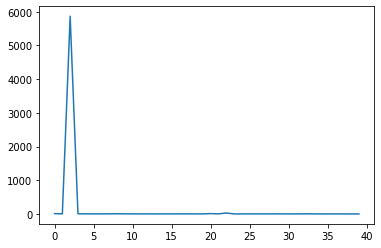

In [35]:
plt.plot(epochs_train_losses)
plt.show

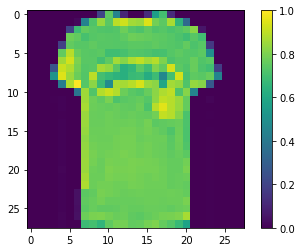

In [37]:
show_image(np.reshape(test_image_tshirt_flatten[0], (28,28)))

In [45]:
test_image = test_image_tshirt_flatten[0]
test_image = np.expand_dims(test_image,axis = 0)
test_image.shape

(1, 784)

In [55]:
encoded,_,_ = encoder(test_image)
encoded = encoded.numpy()
encoded.shape

(1, 64)

In [58]:
decoded = decoder(encoded)
decoded = decoded.numpy()
decoded.shape

(1, 784)

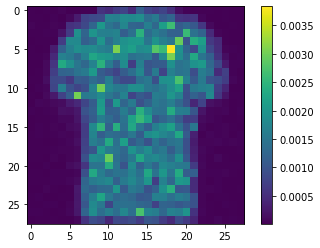

In [59]:
show_image(np.reshape(decoded, (28,28)))

In [ ]:
# Iterate over epochs.
epochs = 10
epochs_train_losses = []
for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))
  losses = []
  for step, x in enumerate(training_X_shuffled):


In [ ]:
# building embedding layer
emb_dim = 64
embedding_model = tf.keras.models.Sequential([
                                tf.keras.layers.Dense(64, activation = 'relu', input_shape=(784,)),
                                tf.keras.layers.Dense(emb_dim, activation='sigmoid'),
                              ])
embedding_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
Total params: 54,400
Trainable params: 54,400
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# take an example and predict output
example = training_X_shuffled[0]
print ("shape of example: ", example.shape)

example_emb = embedding_model.predict(np.expand_dims(example, axis = 0))

print ("shape of example_emb: ", example_emb.shape)

shape of example:  (784,)
shape of example_emb:  (1, 64)


In [ ]:
# Declaring inputs
in_anc = tf.keras.layers.Input(shape = (784,))
in_pos = tf.keras.layers.Input(shape = (784,))
in_neg = tf.keras.layers.Input(shape = (784,))

im_anc_emb = embedding_model(in_anc)
im_pos_emb = embedding_model(in_pos)
im_neg_emb = embedding_model(in_neg)

In [ ]:
# Declaring outputs
out = tf.keras.layers.concatenate([im_anc_emb, im_pos_emb, im_neg_emb], axis = 1)

# the full model
net = tf.keras.Model(inputs = [in_anc, in_pos, in_neg], outputs = out)

net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64)           54400       input_1[0][0]                    
                                                                 input_2[0][0]                

Triplet loss:
  dp : distance between anchor and positive example
  dn : distance between anchor and negative example
  The job of training would make sure dp < dn
  if decrease dn by a scale factor then condition on dp would be tighter
  dp < dn - e

  so the condition would be 

  dp-dn+e < = 0

  and loss would be

  Loss = max (dp-dn+e, 0) // whichever is max will be reduced during training

In [ ]:
# Defining triplet loss
def triplet_loss(emb_dim, alpha):
  def loss (y_truth, y_pred):
    anc, pos, neg = y_pred[:, :emb_dim], y_pred[:, emb_dim:2*emb_dim], y_pred[:, 2*emb_dim:3*emb_dim]
    dp = tf.reduce_mean(tf.square(anc - pos), axis = 1)
    dn = tf.reduce_mean(tf.square(anc - neg), axis = 1)
    return tf.maximum(dp-dn+alpha, 0.)
  return loss

In [ ]:
def data_generator(batch_size, emb_dim):
  while True:
    x = create_batch (batch_size)
    y = np.zeros((batch_size, 3*emb_dim))
    yield x, y


In [ ]:
batch_size = 60
epochs = 20
steps_per_epoch = int(len(training_X_shuffled)/batch_size)
net.compile(loss = triplet_loss(emb_dim, alpha = 0.2), optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))

Epoch 1/20
200/200 [==============================] - 1s 4ms/step - loss: 0.1982
Epoch 2/20
200/200 [==============================] - 1s 4ms/step - loss: 0.1970
Epoch 3/20
200/200 [==============================] - 1s 4ms/step - loss: 0.1970
Epoch 4/20
200/200 [==============================] - 1s 4ms/step - loss: 0.1971
Epoch 5/20
200/200 [==============================] - 1s 4ms/step - loss: 0.1968
Epoch 6/20
200/200 [==============================] - 1s 4ms/step - loss: 0.1969
Epoch 7/20
200/200 [==============================] - 1s 4ms/step - loss: 0.1968
Epoch 8/20
200/200 [==============================] - 1s 4ms/step - loss: 0.1968
Epoch 9/20
200/200 [==============================] - 1s 4ms/step - loss: 0.1968
Epoch 10/20
200/200 [==============================] - 1s 4ms/step - loss: 0.1970
Epoch 11/20
200/200 [==============================] - 1s 4ms/step - loss: 0.1969
Epoch 12/20
200/200 [==============================] - 1s 4ms/step - loss: 0.1968
Epoch 13/20
200/200 [====

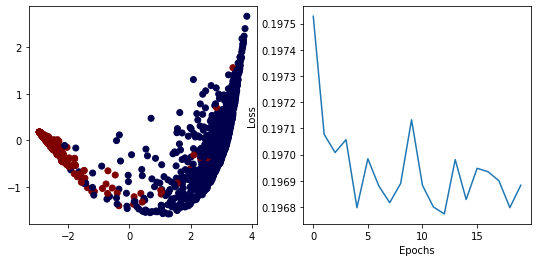

In [ ]:
net.fit(data_generator(batch_size, emb_dim), epochs=epochs, steps_per_epoch=steps_per_epoch,
        callbacks = [
                    PCAPlotter(plt, embedding_model, testing_X_shuffled, test_y_shuffled)
        ])

In [ ]:
def initialize_base_network():
    input = Input(shape=(28,28,), name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)

    return Model(inputs=input, outputs=x)